In [49]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from sklearn.cluster import KMeans
from kneed import KneeLocator

- Copper: HG
- Bund: RX
- Crude Oil: CL
- EURUSD: EC
- Gold: GC
- Nasdaq: NQ
- S&P500 Mini: ES
- Silver: SI
- Soybeans: SO
- UST: TY

In [37]:
# User-specified parameters for empirical PDF generation
ticker = "GC"                           # Ticker of underlying
interval = 15                           # Holding period: 5, 10, 15, 30, 60 minutes
partitions = [0.65, 0.8]                # Train, cross-validation, and test set split


# Load dataset for user-specified ticker
with open("clean-data/futures_ticks.pkl", "rb") as f:
    tick_size = pickle.load(f)[ticker]
futures_df = pd.read_csv(f"./clean-data/{ticker}.csv", index_col='datetime', parse_dates=True)

# Resample training set into user-specified intervals
resampled_o = futures_df['open'].resample(f"{interval}min").first()
resampled_h = futures_df['high'].resample(f"{interval}min").max()
resampled_l = futures_df['low'].resample(f"{interval}min").min()
resampled_c = futures_df['close'].resample(f"{interval}min").last()
resampled_v = futures_df['volume'].resample(f"{interval}min").sum()
futures_df = pd.DataFrame(
    {
        'open': resampled_o,
        'high': resampled_h,
        'low': resampled_l,
        'close': resampled_c,
        'volume': resampled_v,
    }
)
futures_df.dropna(inplace=True)

# Partition resampled dataset into training, cross-validation, and test sets
train_df = futures_df.iloc[:int(partitions[0]*len(futures_df))].copy()
cv_df = futures_df.iloc[:int(partitions[1]*len(futures_df))].copy()
test_df = futures_df.copy()

# Construct Range, RangeUp, RangeDown responses for training set
train_df["fwd_range"] = ((train_df["high"] - train_df["low"]) / tick_size).shift(-1)
train_df["fwd_range_up"] = ((train_df["high"] - train_df["open"]) / tick_size).shift(-1)
train_df["fwd_range_down"] = ((train_df["open"] - train_df["low"]) / tick_size).shift(-1)

# Define feature and response names
features = ["delta_feat", "vol_feat", "volume_feat"]
responses = ["fwd_range", "fwd_range_up", "fwd_range_down"]

# Compute simple initial alpha and beta to be used for all priors
beta = 1
alphas = train_df[responses].mean()

In [7]:
def volume_function(series, param):
    # Raw volumes for each period
    if param == 1:
        return series
    
    # Simple moving average over (param) rolling window
    if param > 1:
        return series.rolling(param).mean()
    
    # Exponential moving average with (param) decay
    if param < 1:
        return series.ewm(alpha=param, adjust=False).mean()

def vol_function(series, param):
    # Standard deviation from simple mean over (param) rolling window
    if param > 1:
        return series.rolling(param).std()
    
    # Standard deviation from exponential moving average with (param) decay
    if param < 1:
        ema = series.ewm(alpha=param, adjust=False).mean()
        square_dev = (ema - series)**2
        return square_dev.ewm(alpha=param, adjust=False).mean()

- Likelihood of each range response and regime assumed to follow a Poisson($\lambda$) distribution
- Each $\lambda$ prior is a Gamma($\alpha$, $\beta$) distribution (scale $\beta$); choice of initial $\alpha$ and $\beta$ should inisignificant since we have quite some data given to us
- Posterior for $\lambda$ would be Gamma($\alpha + \sum_{i=1}^n{x_i}$, $\frac{\beta}{n\beta+1}$)
- Conveniently, posterior predictive distribution is a Negative Binomial($\alpha + \sum_{i=1}^n{x_i}$, $\frac{n\beta + 1}{(n+1)\beta + 1}$): all ripped from wikipedia haha (https://en.wikipedia.org/wiki/Conjugate_prior). We use this to calculate future likelihoods and for the bayesian empirical pdf 

In [56]:
def epdf_construction(volume_param, vol_param):
    # Construct volume, volatility and delta features
    tuning_df = train_df.copy()
    tuning_df["delta_feat"] = tuning_df["close"].diff()
    tuning_df["volume_feat"] = volume_function(tuning_df["volume"], volume_param)
    tuning_df["vol_feat"] = vol_function(tuning_df["delta_feat"], vol_param)
    tuning_df.dropna(inplace=True)

    # Find optimal number of regimes from a KMeans clustering algorithm
    n_regimes = [_ for _ in range(2, 8)]
    regime_wcss = []
    for reg in n_regimes:
        kmeans = KMeans(n_clusters=reg, random_state=10).fit(tuning_df[features])
        regime_wcss.append(kmeans.inertia_)
    regimes = KneeLocator(n_regimes, regime_wcss, curve="convex", direction="decreasing").knee

    # Build empirical PDF for each response and regime
    kmeans = KMeans(n_clusters=regimes, random_state=10)
    tuning_df["regime"] = kmeans.fit_predict(tuning_df[features])
    obs_sums = tuning_df[responses+["regime"]].groupby("regime").sum()
    empirical_pdfs = {resp: {} for resp in responses}
    n = len(tuning_df)
    for resp in obs_sums:
        for reg, sum in obs_sums[resp].items():
            empirical_pdfs[resp][reg] = nbinom(n=alphas[resp]+sum, p=(n*beta+1)/((n+1)*beta+1))

    return regimes, kmeans, empirical_pdfs

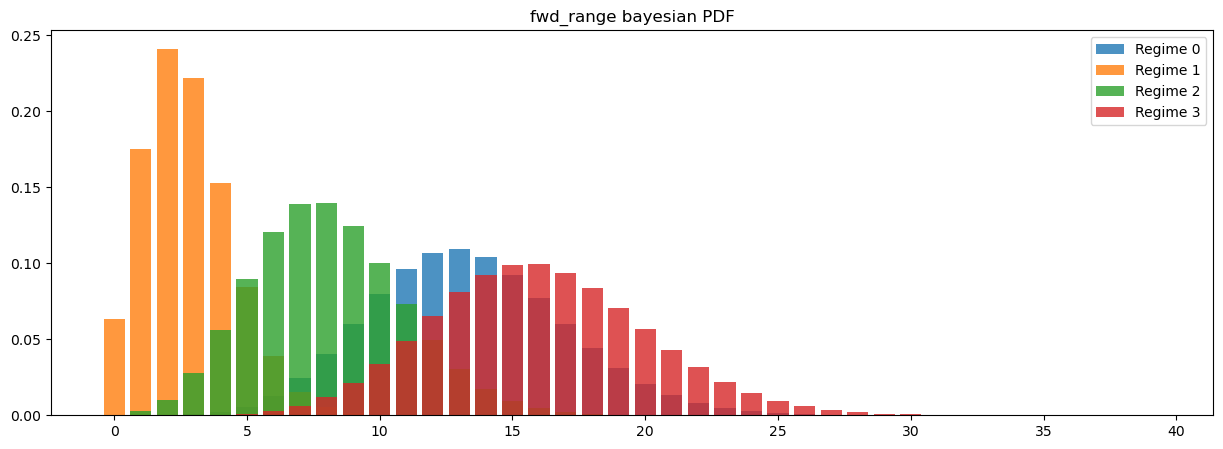

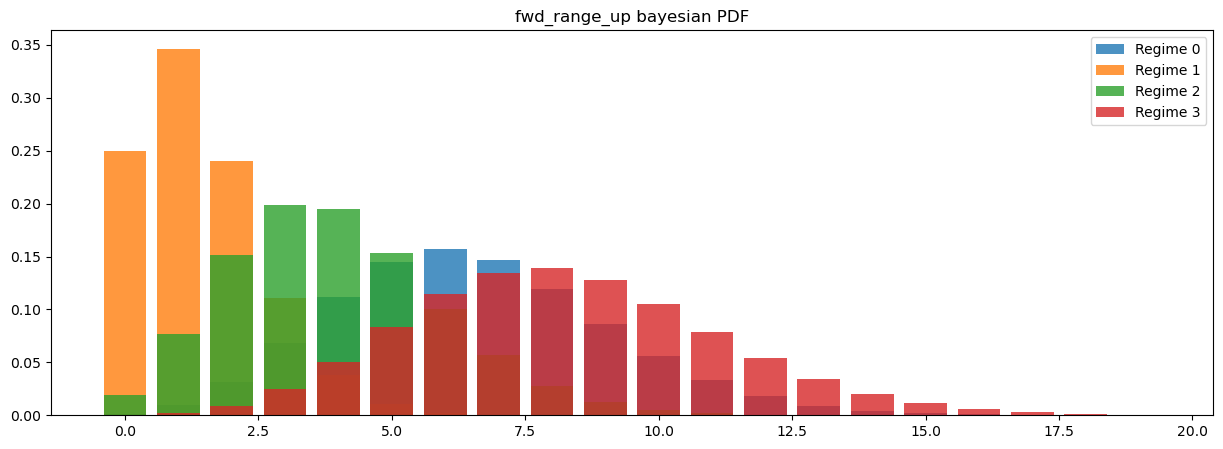

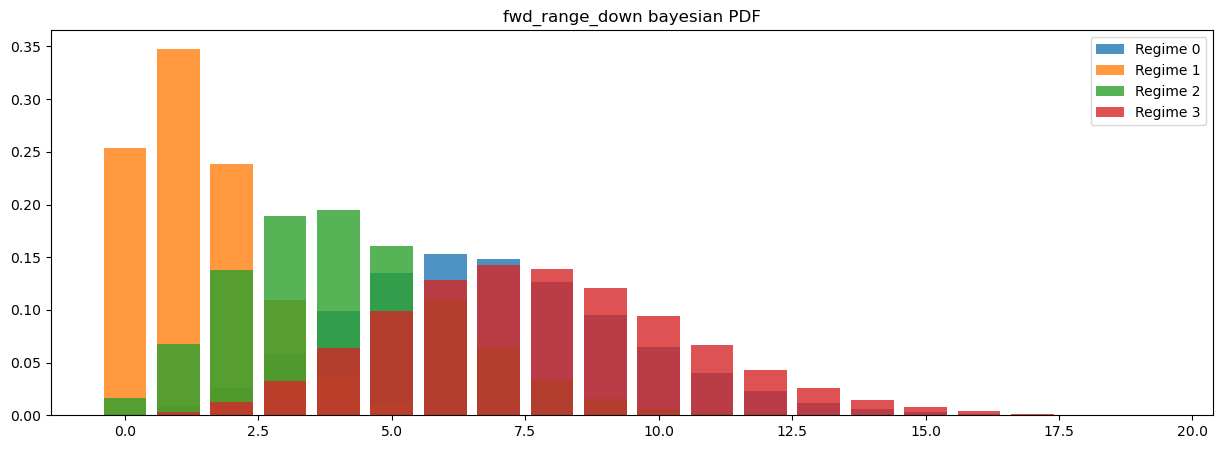

In [67]:
# Plot empirical PDFs given volume and volatility feature functions
def plot_epdfs(volume_param, vol_param):
    regimes, _, epdfs = epdf_construction(volume_param, vol_param)
    x_max = train_df[responses].mean()
    for response, resp_epdf in epdfs.items():
        x_range = [_ for _ in range(0, int(x_max[response])+1)]
        plt.figure(figsize=(15, 5))
        plt.title(f"{response} bayesian PDF")
        for i in range(regimes):
            plt.bar(x_range, [resp_epdf[i].pmf(x) for x in x_range], label=f"Regime {i}", alpha=0.8)
        plt.legend()

plot_epdfs(5, 30)

In [78]:
cv_df["fwd_range"] = ((cv_df["high"] - cv_df["low"]) / tick_size).shift(-1)
cv_df["fwd_range_up"] = ((cv_df["high"] - cv_df["open"]) / tick_size).shift(-1)
cv_df["fwd_range_down"] = ((cv_df["open"] - cv_df["low"]) / tick_size).shift(-1)

# Define log-likelihood computation algorithm for cross-validation optimization
def log_likelihood(kmeans, epdfs, volume_param, vol_param):
    optimizing_df = cv_df.copy()
    optimizing_df["delta_feat"] = optimizing_df["close"].diff()
    optimizing_df["volume_feat"] = volume_function(optimizing_df["volume"], volume_param)
    optimizing_df["vol_feat"] = vol_function(optimizing_df["delta_feat"], vol_param)
    optimizing_df = optimizing_df.iloc[int(partitions[0]*len(futures_df)):].copy()
    optimizing_df.dropna(inplace=True)
    optimizing_df["regime"] = kmeans.predict(optimizing_df[features])

    log_likelihoods = {}
    for resp in responses:
        resp_reg_df = optimizing_df[[resp, "regime"]]
        resp_pdf = epdfs[resp]
        obs_df = resp_reg_df.groupby("regime").value_counts()
        resp_log_likelihood = 0
        for reg in optimizing_df["regime"].unique():
            reg_obs_df = obs_df[reg]
            reg_resp_pdf = resp_pdf[reg]
            for spread, obs in reg_obs_df.items():
                print(reg_resp_pdf.pmf(spread))
                resp_log_likelihood += obs * np.log(reg_resp_pdf.pmf(spread))
                
        log_likelihoods[resp] = resp_log_likelihood

    return log_likelihoods

In [ ]:
regime, kmean, epdf = epdf_construction(1, 30)
log_likelihood(kmean, epdf, 1, 30)

0.0
3.3665345164985094e-07
1.7604056443855999e-09
0.0
0.0
0.0
2.104851070092484e-24
0.0
0.0
0.0
0.0
0.0
0.0
0.0013173544904890966
0.0
0.0
4.960136629165382e-12
0.0
0.0
8.062762518357407e-15
0.0
0.0
7.986137994693662e-18
0.0
5.040887134604271e-21
0.0
0.0
0.0
0.0
6.000975814070554e-28
0.0
0.0
0.0
0.0
0.0
3.1777457264198806e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.816697296239558e-39
0.0
0.0
0.0
0.0919610434635858
0.020370349141935105
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.724511638329128e-35
0.0
1.4290476094839304e-43
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.019161761633341993
0.0
0.0
0.07473086509948444
0.0
0.0
0.0
0.0
0.0018324563739880071
0.0
0.08507944777444224
0.0
0.0
0.0
7.695374985542133e-05
0.0
0.0
0.0
0.0
0.0
1.5949320414299305e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7809687243948524e-08
0.0
0.018767958354319048
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1258289868652973e-15
0.0
0.0

/var/folders/0k/7dnc4g8j6zq9jpmv13sgsz3w0000gn/T/ipykernel_7982/50522374.py:26: RuntimeWarning: divide by zero encountered in log
  resp_log_likelihood += obs * np.log(reg_resp_pdf.pmf(spread))
/var/folders/0k/7dnc4g8j6zq9jpmv13sgsz3w0000gn/T/ipykernel_7982/50522374.py:26: RuntimeWarning: divide by zero encountered in log
  resp_log_likelihood += obs * np.log(reg_resp_pdf.pmf(spread))
/var/folders/0k/7dnc4g8j6zq9jpmv13sgsz3w0000gn/T/ipykernel_7982/50522374.py:26: RuntimeWarning: divide by zero encountered in log
  resp_log_likelihood += obs * np.log(reg_resp_pdf.pmf(spread))


{'fwd_range': -inf, 'fwd_range_up': -inf, 'fwd_range_down': -inf}

In [ ]:
volume_param_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 15, 20, 25]
vol_param_list = [0.1, 0.3, 0.5, 0.7, 0.9, 30, 40, 50, 60]

# Get log-likelihood for a set of volume and volatility function parameters
optimization_results = []
for volume_param in volume_param_list:
    for vol_param in vol_param_list:
        _, _kmeans, _epdfs = epdf_construction(volume_param, vol_param)
        _log_likelihood = log_likelihood(_kmeans, _epdfs, volume_param, vol_param)
        _log_likelihood["volume_param"] = volume_param
        _log_likelihood["vol_param"] = vol_param
        optimization_results.append(_log_likelihood)

optimization_df = pd.DataFrame(optimization_results)

optimization_df